In [ ]:
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.activations import sigmoid
import matplotlib.pyplot as plt

#Unzipping the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!unzip "/content/drive/MyDrive/dataset(v2).zip" -d "/content/data"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/MyDrive/dataset(v2).zip
replace /content/data/dataset/test-set/10/2022-06-28 15-28-29-7003.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
n


#Loading the dataset

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_images_from_folder(folder_path, target_size=(224, 224)):
    images = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = load_img(img_path, target_size=target_size)
        img_array = img_to_array(img)
        images.append(img_array)
    return np.array(images)

dataset_dir = '/content/data/dataset/train-set'

class_folders = [f.path for f in os.scandir(dataset_dir) if f.is_dir()]

class_no = 5
class_names = ['melted_snow', 'dry_asphalt_slight', 'water_concrete_severe', 'wet_concrete_smooth', 'dry_asphalt_smooth']

selected_class_folders = [folder for folder in class_folders if os.path.basename(folder) in class_names]

max_samples_per_class_train = 600
max_samples_per_class_val = 200
train_data = []
val_data = []

for folder in selected_class_folders:
    class_name = os.path.basename(folder)
    images = [os.path.join(folder, img) for img in os.listdir(folder)]
    np.random.shuffle(images)
    train_images = images[:max_samples_per_class_train]
    val_images = images[max_samples_per_class_train:max_samples_per_class_train+max_samples_per_class_val]
    labels_train = [class_names.index(class_name)] * len(train_images)
    labels_val = [class_names.index(class_name)] * len(val_images)
    train_data.extend(list(zip(train_images, labels_train)))
    val_data.extend(list(zip(val_images, labels_val)))

np.random.shuffle(train_data)
np.random.shuffle(val_data)

train_image_paths, train_labels = zip(*train_data)
val_image_paths, val_labels = zip(*val_data)
train_image_paths = np.array(train_image_paths)
train_labels = np.array(train_labels)
val_image_paths = np.array(val_image_paths)
val_labels = np.array(val_labels)

def load_and_preprocess(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    return img, label

train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_labels))
train_dataset = train_dataset.map(lambda x, y: load_and_preprocess(x, y))
train_dataset = train_dataset.shuffle(buffer_size=len(train_data)).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_image_paths, val_labels))
val_dataset = val_dataset.map(lambda x, y: load_and_preprocess(x, y))
val_dataset = val_dataset.shuffle(buffer_size=len(val_data)).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

print("Class Names:", class_names)
print("Training Dataset Spec:", train_dataset.element_spec)
print("Validation Dataset Spec:", val_dataset.element_spec)


Class Names: ['melted_snow', 'dry_asphalt_slight', 'water_concrete_severe', 'wet_concrete_smooth', 'dry_asphalt_smooth']
Training Dataset Spec: (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))
Validation Dataset Spec: (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))


#visualising the data

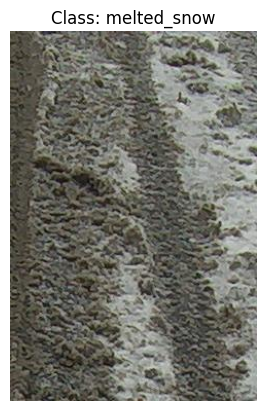

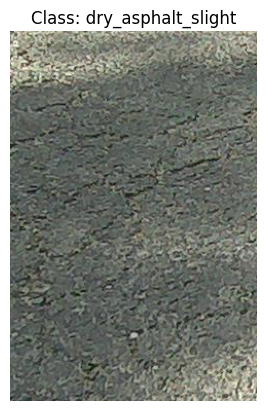

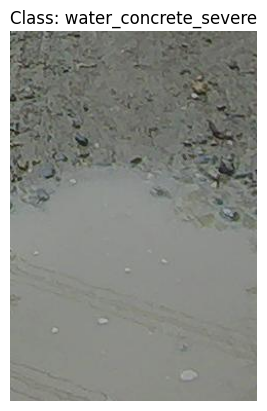

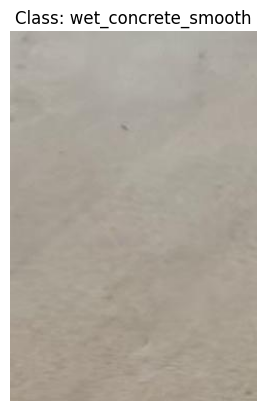

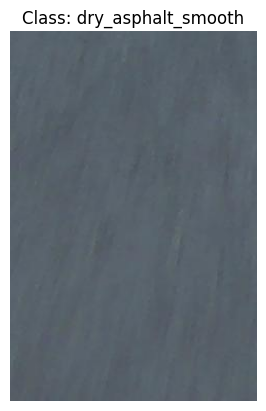

In [ ]:
def show_random_image_from_class(image_paths, labels, class_idx, class_names):
    class_indices = np.where(labels == class_idx)[0]
    random_index = np.random.choice(class_indices)
    image_path = image_paths[random_index]
    img = load_img(image_path)
    plt.imshow(img)
    plt.title(f"Class: {class_names[class_idx]}")
    plt.axis('off')
    plt.show()
    return img

for class_idx in range(class_no):
    show_random_image_from_class(train_image_paths, train_labels, class_idx, class_names)


#Model generation, compilation and summary

In [ ]:
def create_efficientnet_model(input_shape, num_classes, top_n_layers_trainable=10):
    backbone = EfficientNetB0(include_top=False, input_shape=input_shape, weights='imagenet')
    backbone.trainable = False

    for layer in backbone.layers[-top_n_layers_trainable:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True

    global_average_pooling = GlobalAveragePooling2D()(backbone.output)
    output_layer = Dense(num_classes, activation='softmax')(global_average_pooling)
    model = Model(inputs=backbone.input, outputs=output_layer)
    return model

input_shape = (224, 224, 3)
num_classes = 5

model = create_efficientnet_model(input_shape, num_classes, top_n_layers_trainable=10)
model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['normalization[0][0]']   

#Fitting the model

In [ ]:
epochs = 6
steps_per_epoch = len(train_dataset)
validation_steps = len(val_dataset)

history = model.fit(
    train_dataset,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps
)


Epoch 1/6
94/94 [==============================] - 34s 156ms/step - loss: 0.5577 - accuracy: 0.7817 - val_loss: 0.3268 - val_accuracy: 0.8710
Epoch 2/6
94/94 [==============================] - 13s 99ms/step - loss: 0.2951 - accuracy: 0.8890 - val_loss: 0.2700 - val_accuracy: 0.8910
Epoch 3/6
94/94 [==============================] - 14s 96ms/step - loss: 0.2198 - accuracy: 0.9170 - val_loss: 0.2137 - val_accuracy: 0.9220
Epoch 4/6
94/94 [==============================] - 13s 95ms/step - loss: 0.1758 - accuracy: 0.9357 - val_loss: 0.2598 - val_accuracy: 0.8960
Epoch 5/6
94/94 [==============================] - 13s 103ms/step - loss: 0.1572 - accuracy: 0.9437 - val_loss: 0.2484 - val_accuracy: 0.9160
Epoch 6/6
94/94 [==============================] - 12s 99ms/step - loss: 0.1521 - accuracy: 0.9413 - val_loss: 0.2479 - val_accuracy: 0.8990


#Visualise the predictions

1/1 [==============================] - 3s 3s/step


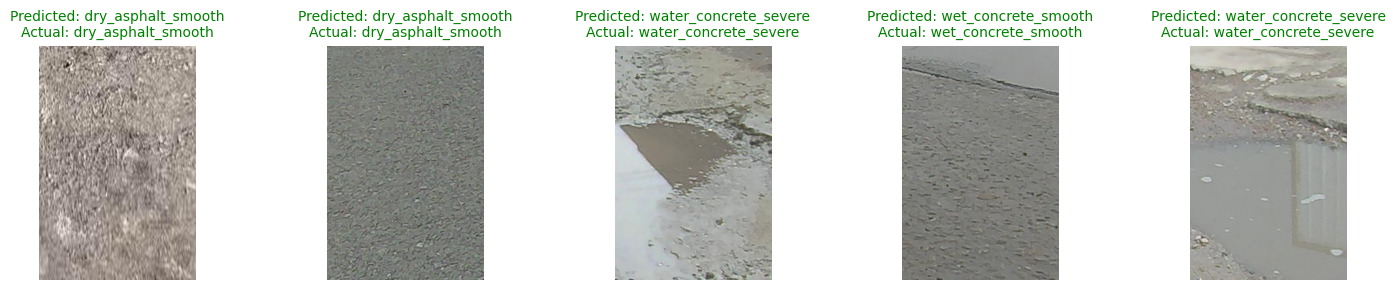

In [ ]:
def visualize_predictions(model, val_image_paths, val_labels, class_names, num_images=5):
    random_indices = np.random.choice(len(val_image_paths), size=num_images, replace=False)
    validation_images = val_image_paths[random_indices]
    validation_labels = val_labels[random_indices]

    preprocessed_validation_images = [load_and_preprocess(image_path, label)[0] for image_path, label in zip(validation_images, validation_labels)]
    preprocessed_validation_images = np.array(preprocessed_validation_images)

    predictions = model.predict(preprocessed_validation_images)

    plt.figure(figsize=(15, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(load_img(validation_images[i]))
        predicted_label = np.argmax(predictions[i])
        actual_label = validation_labels[i]
        if predicted_label == actual_label:
            plt.title(f'Predicted: {class_names[predicted_label]}\nActual: {class_names[actual_label]}', color='green', fontsize=10)
        else:
            plt.title(f'Predicted: {class_names[predicted_label]}\nActual: {class_names[actual_label]}', color='red', fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


visualize_predictions(model, val_image_paths, val_labels, class_names, num_images=5)

#Visualising the metrics loss and accuracy

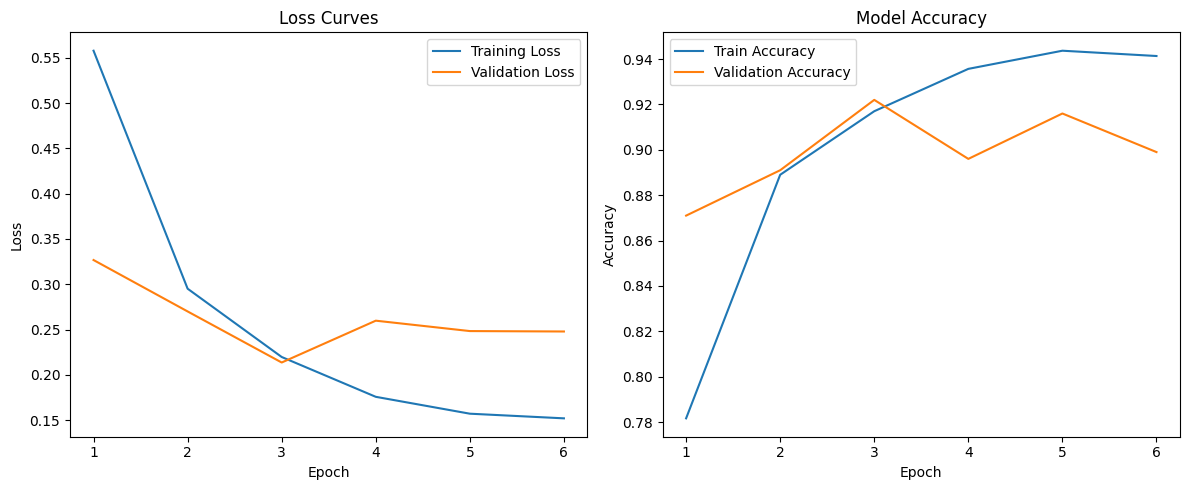

In [ ]:
def plot_loss_and_accuracy(history):
    epochs = range(1, len(history.history['accuracy']) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()

    # Plot accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], label='Train Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

plot_loss_and_accuracy(history)


#Getting predictions and plotting the confusion matrix

In [ ]:
def get_predictions(model, dataset):
    y_pred = []
    y_true = []
    for x, y in dataset:
        y_true.extend(y.numpy())
        y_pred.extend(np.argmax(model.predict(x, verbose = 0), axis=-1))
    return y_true, y_pred

val_true_labels, val_pred_labels = get_predictions(model, val_dataset)


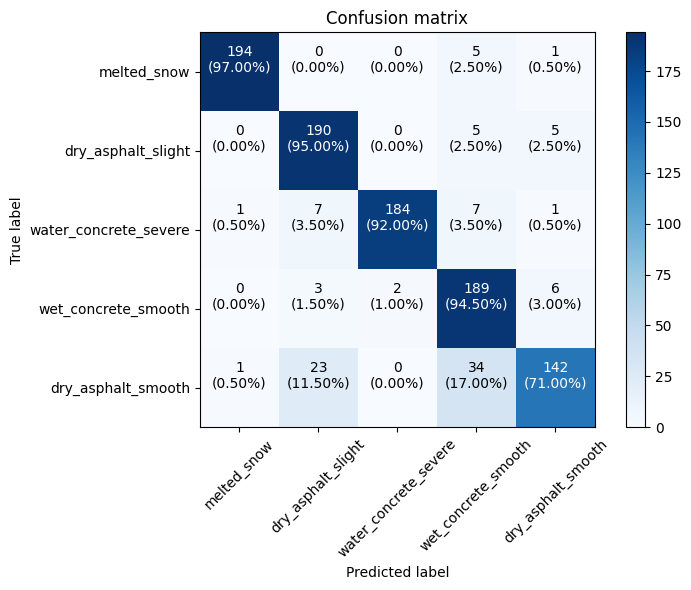

In [ ]:

import  itertools
def plot_confusion_matrix(y_true, y_pred, class_names):
    class_indices = {class_name: i for i, class_name in enumerate(class_names)}
    class_idxs = [class_indices[class_name] for class_name in class_names]

    cm = confusion_matrix(y_true, y_pred, labels=class_idxs)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
    plt.yticks(np.arange(len(class_names)), class_names)
    plt.colorbar()

    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_normalized = np.nan_to_num(cm_normalized)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd') + "\n({:.2f}%)".format(cm_normalized[i, j] * 100),
                 horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(val_true_labels, val_pred_labels, class_names)


#MobileNetV3 as base model

In [ ]:
from tensorflow.keras.applications import MobileNetV3Small

def create_mobilenetv3base_model(input_shape, num_classes, top_n_layers_trainable=10):
    backbone = MobileNetV3Small(include_top=False, input_shape=input_shape, weights='imagenet')
    backbone.trainable = False

    for layer in backbone.layers[-top_n_layers_trainable:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True

    global_average_pooling = GlobalAveragePooling2D()(backbone.output)
    output_layer = Dense(num_classes, activation='softmax')(global_average_pooling)
    model = Model(inputs=backbone.input, outputs=output_layer)
    return model

input_shape = (224, 224, 3)
num_classes = 5

mobilenetv3base = create_mobilenetv3base_model(input_shape, num_classes, top_n_layers_trainable=10)
mobilenetv3base.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])
mobilenetv3base.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 224, 224, 3)          0         ['input_2[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling_2[0][0]']         
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 112, 112, 16)         64        ['Conv[0][0]']                
 lization)                                                                                  

#Fitting the model

In [ ]:
epochs = 6
steps_per_epoch = len(train_dataset)
validation_steps = len(val_dataset)

historyv3 = mobilenetv3base.fit(
    train_dataset,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps
)


Epoch 1/6
94/94 [==============================] - 17s 87ms/step - loss: 0.6267 - accuracy: 0.7720 - val_loss: 0.4368 - val_accuracy: 0.8190
Epoch 2/6
94/94 [==============================] - 8s 45ms/step - loss: 0.3490 - accuracy: 0.8717 - val_loss: 0.3492 - val_accuracy: 0.8710
Epoch 3/6
94/94 [==============================] - 8s 56ms/step - loss: 0.2537 - accuracy: 0.9047 - val_loss: 0.3154 - val_accuracy: 0.8820
Epoch 4/6
94/94 [==============================] - 9s 56ms/step - loss: 0.2333 - accuracy: 0.9143 - val_loss: 0.2960 - val_accuracy: 0.8840
Epoch 5/6
94/94 [==============================] - 8s 49ms/step - loss: 0.1784 - accuracy: 0.9390 - val_loss: 0.2883 - val_accuracy: 0.8850
Epoch 6/6
94/94 [==============================] - 7s 45ms/step - loss: 0.1526 - accuracy: 0.9477 - val_loss: 0.2923 - val_accuracy: 0.8920


#Visualisation

1/1 [==============================] - 2s 2s/step


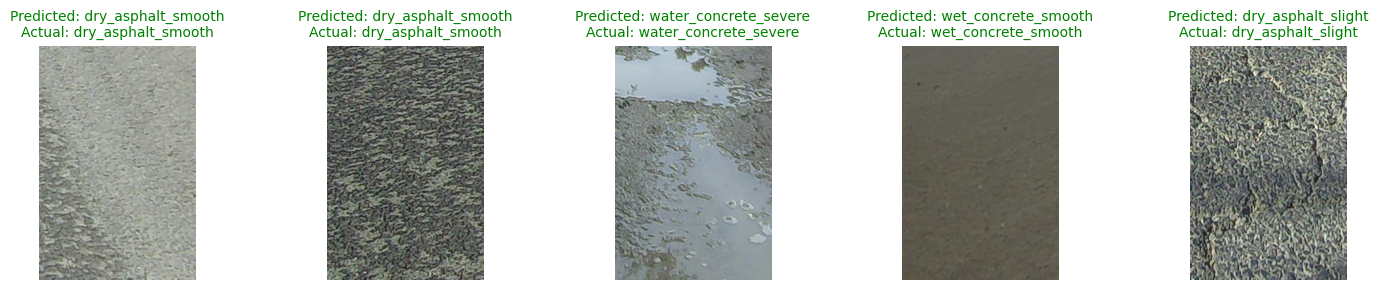

In [ ]:
visualize_predictions(mobilenetv3base, val_image_paths, val_labels, class_names, num_images=5)

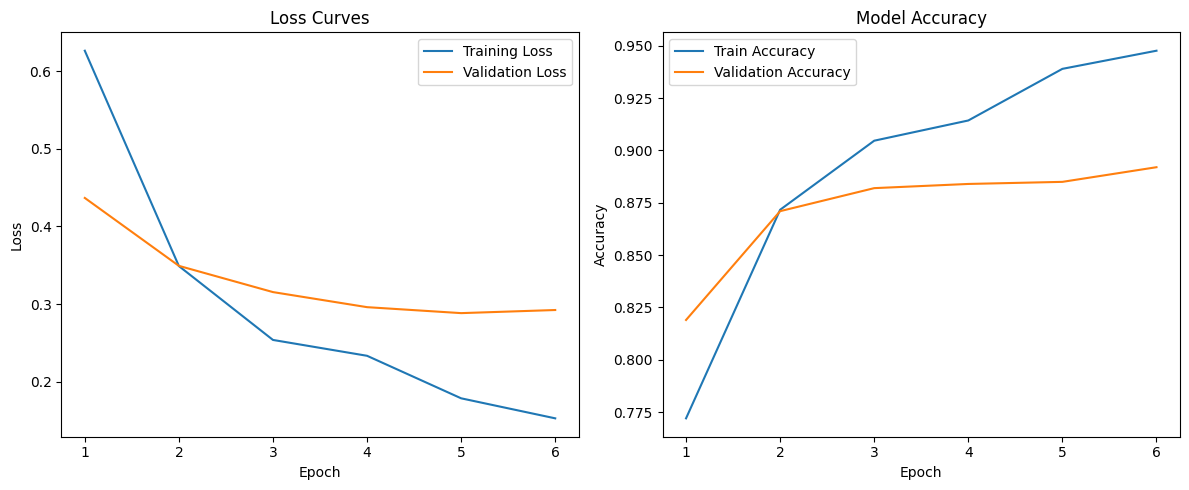

In [ ]:
plot_loss_and_accuracy(historyv3)

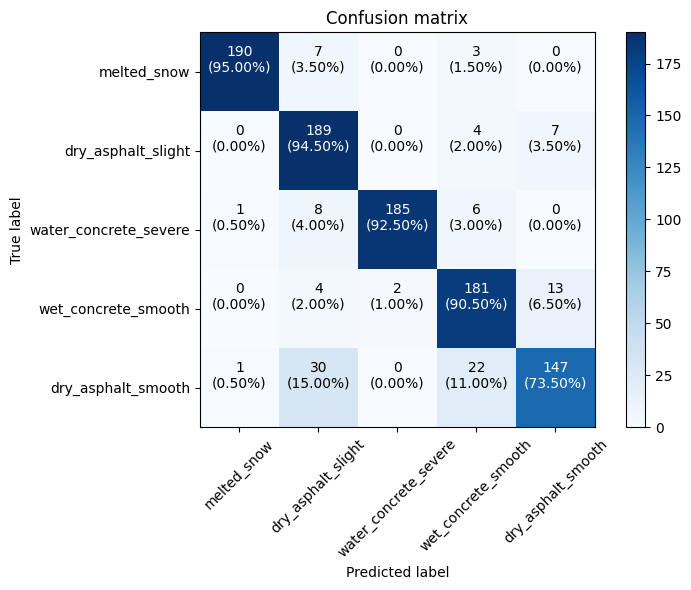

In [ ]:
val_true_labels2, val_pred_labels2 = get_predictions(mobilenetv3base, val_dataset)
plot_confusion_matrix(val_true_labels2, val_pred_labels2, class_names)

#VGG16

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

def create_vgg16_model(input_shape, num_classes, top_n_layers_trainable=5):
    backbone = VGG16(include_top=False, input_shape=input_shape, weights='imagenet')
    backbone.trainable = False
sa
    global_average_pooling = GlobalAveragePooling2D()(backbone.output)
    fc1 = Dense(512, activation='relu')(global_average_pooling)
    dropout1 = Dropout(0.25)(fc1)
    fc2 = Dense(256, activation='relu')(dropout1)
    dropout2 = Dropout(0.25)(fc2)
    output_layer = Dense(num_classes, activation='softmax')(dropout2)
    model = Model(inputs=backbone.input, outputs=output_layer)
    return model

input_shape = (224, 224, 3)
num_classes = 5

VGG16_b = create_vgg16_model(input_shape, num_classes, top_n_layers_trainable=10)
VGG16_b.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])
VGG16_b.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
epochs = 6
steps_per_epoch = len(train_dataset)
validation_steps = len(val_dataset)

history_vgg16 = VGG16_b.fit(
    train_dataset,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps
)

Epoch 1/6
94/94 [==============================] - 39s 298ms/step - loss: 0.8872 - accuracy: 0.6903 - val_loss: 0.4623 - val_accuracy: 0.8230
Epoch 2/6
94/94 [==============================] - 19s 179ms/step - loss: 0.4963 - accuracy: 0.8217 - val_loss: 0.4409 - val_accuracy: 0.8300
Epoch 3/6
94/94 [==============================] - 21s 184ms/step - loss: 0.4170 - accuracy: 0.8477 - val_loss: 0.3858 - val_accuracy: 0.8610
Epoch 4/6
94/94 [==============================] - 20s 190ms/step - loss: 0.3585 - accuracy: 0.8653 - val_loss: 0.3946 - val_accuracy: 0.8420
Epoch 5/6
94/94 [==============================] - 22s 186ms/step - loss: 0.2837 - accuracy: 0.8970 - val_loss: 0.3692 - val_accuracy: 0.8630
Epoch 6/6
94/94 [==============================] - 20s 179ms/step - loss: 0.2595 - accuracy: 0.9013 - val_loss: 0.3253 - val_accuracy: 0.8810


1/1 [==============================] - 2s 2s/step


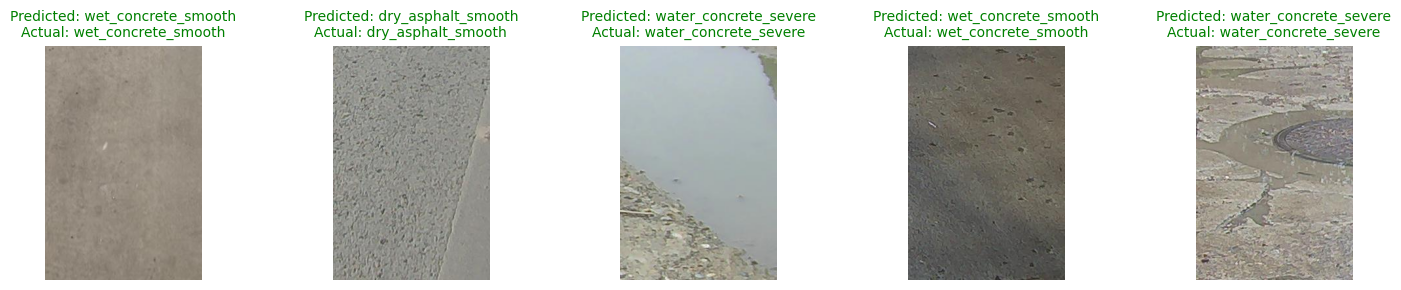

In [ ]:
visualize_predictions(VGG16_b, val_image_paths, val_labels, class_names, num_images=5)

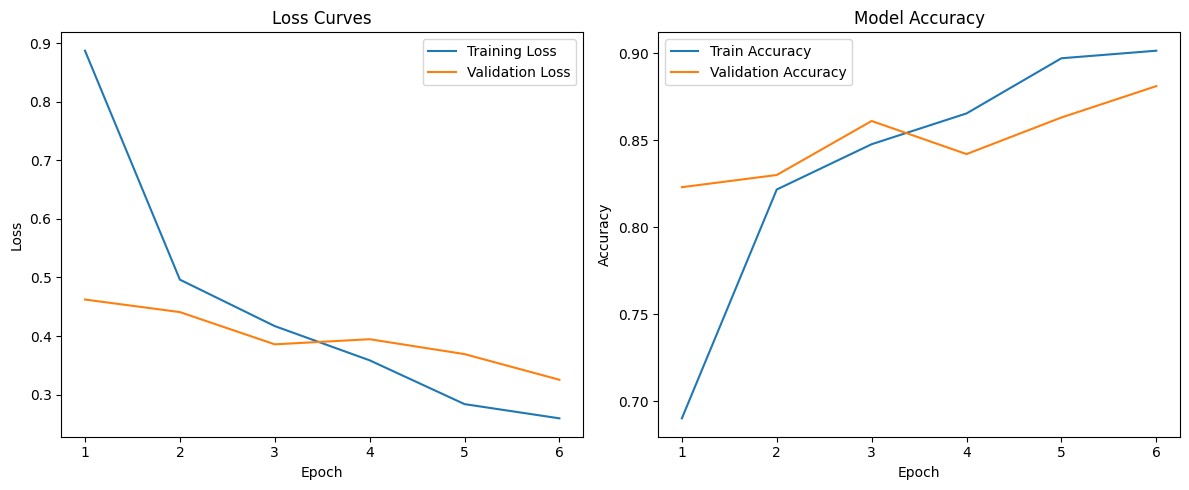

In [ ]:
plot_loss_and_accuracy(history_vgg16)

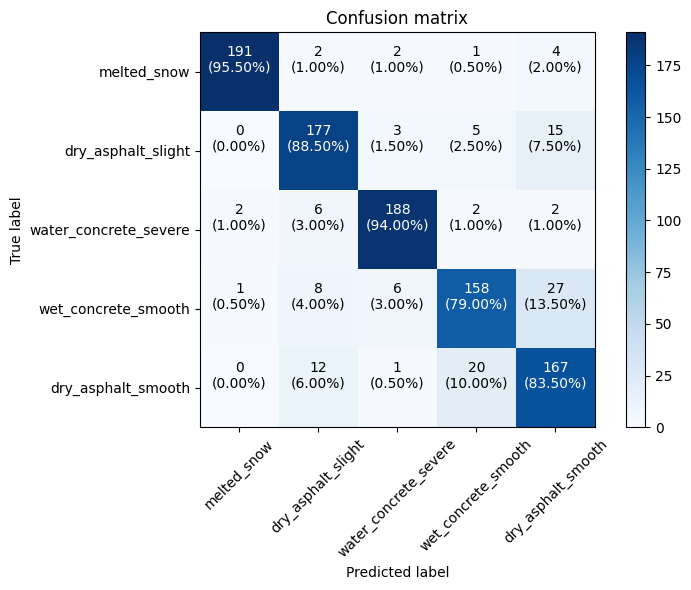

In [ ]:
val_true_labels3, val_pred_labels3 = get_predictions(VGG16_b, val_dataset)
plot_confusion_matrix(val_true_labels3, val_pred_labels3, class_names)